In [1]:
import collections
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')
    
from Bio import SeqIO
import gffutils

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

## Filtering

In [3]:
specied_csv = os.path.join(os.getcwd(), 'data/bac_dive/species.csv')
ncbi_folder = os.path.join(os.getcwd(), 'data/ncbi/raw/')

In [4]:
species_df = pd.read_csv(specied_csv)
species_df.head()

,bacdive_id,domain,specie_name,temperature,temperature_range
0,1,Bacteria,Acetobacter aceti,26.0,mesophilic
1,3,Bacteria,Acetobacter cerevisiae,26.0,mesophilic
2,4,Bacteria,Acetobacter pasteurianus,26.0,mesophilic
3,8,Bacteria,Acetobacter orleanensis,28.0,mesophilic
4,9,Bacteria,Acetobacter lovaniensis,28.0,mesophilic


In [5]:
def specie_with_sequence_and_annotations(species_df, ncbi_folder):
    output = []
    for tpl in species_df.itertuples():
        name = tpl.specie_name.lower().replace(' ', '_')
        fasta_path = os.path.join(ncbi_folder, f'{name}.fasta')
        gff_path = os.path.join(ncbi_folder, f'{name}.gff')
        if os.path.isfile(fasta_path) and os.path.isfile(gff_path):
            output.append([
                tpl.bacdive_id,
                tpl.domain,
                tpl.specie_name,
                tpl.temperature,
                tpl.temperature_range,
            ])
    
    return pd.DataFrame(output, columns=species_df.columns)

In [6]:
species_w_seq = specie_with_sequence_and_annotations(species_df, ncbi_folder)

In [7]:
species_w_seq.shape

(2348, 5)

## Distribution

In [8]:
temperature_ranges = {
    'psychrophilic': (-20.0, 24.0),
    'mesophilic': (24.0, 40.0),
    'thermophilic': (40.0, 80.0),
    'hyperthermophilic': (80.0, 150.0),
}
ranges = ['psychrophilic', 'mesophilic', 'thermophilic', 'hyperthermophilic']

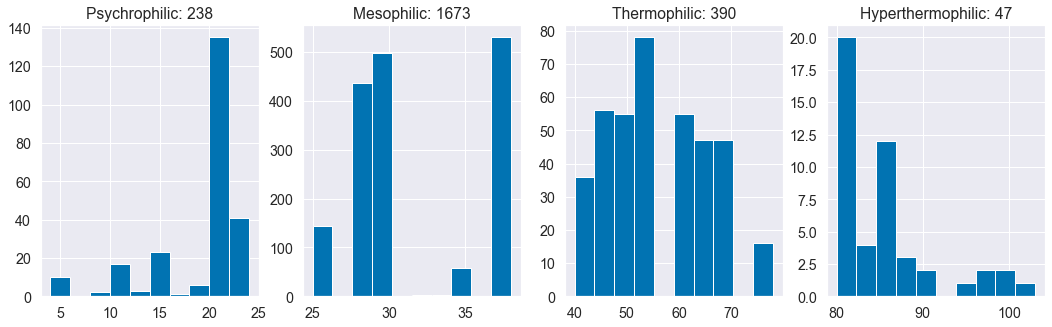

In [9]:
f, axes = plt.subplots(1, 4, figsize=(18, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    v = species_w_seq[species_w_seq['temperature_range'] == ranges[i]]['temperature']
    v.hist(ax=ax)
    ax.set_title(f'{ranges[i].title()}: {len(v)}')

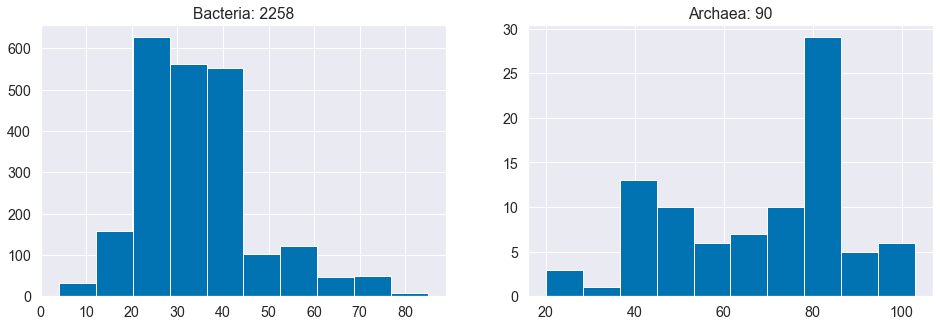

In [10]:
f, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.flatten()

domains = ['Bacteria', 'Archaea']
for i, ax in enumerate(axes):
    v = species_w_seq[species_w_seq['domain'] == domains[i]]['temperature']
    v.hist(ax=ax)
    ax.set_title(f'{domains[i]}: {len(v)}')

## mRNA extraction

In [11]:
specie_name = 'Bifidobacterium thermophilum'
specie_name_ = specie_name.lower().replace(' ', '_')
fasta_path = os.path.join(ncbi_folder, f'{specie_name_}.fasta')
gff_path = os.path.join(ncbi_folder, f'{specie_name_}.gff')

In [12]:
def load_fasta_records(path):
    records = []
    with open(path, 'r') as f:
        for record in SeqIO.parse(f, 'fasta'):
            records.append(record)
    return records

In [13]:
records = load_fasta_records(fasta_path)
records

[SeqRecord(seq=Seq('CAACACGACACAGCATGTGGATAATTCTTCGGAGTTTTCCACATCGCTTACCAA...CGT', SingleLetterAlphabet()), id='NC_020546.1', name='NC_020546.1', description='NC_020546.1 Bifidobacterium thermophilum RBL67, complete genome', dbxrefs=[])]

In [14]:
db = gffutils.create_db(gff_path, ':memory:')

In [15]:
feature_types = set()
for f in db.all_features():
    feature_types.add(f.featuretype)
    
sorted(feature_types)

['CDS',
 'RNase_P_RNA',
 'SRP_RNA',
 'direct_repeat',
 'exon',
 'gene',
 'pseudogene',
 'rRNA',
 'region',
 'riboswitch',
 'tRNA',
 'tmRNA']

In [18]:
for f in db.features_of_type('CDS'):
    print(f.start, f.end)
    print(f.attributes['Name'][0])
    break

268 2190
WP_015449535.1


In [38]:
records__ = {
    r.name: r
    for r in load_fasta_records(fasta_path)
}

In [79]:
genes__ = list(db.features_of_type('gene'))
cds__ = list(db.features_of_type('CDS'))
print(len(genes__), len(cds__))

1684 1687


In [104]:
v = 12
for i, f in enumerate(db.features_of_type('gene')):
    if i == v:
        print(f.start, f.end, f.strand)
        print(f.__dict__)
        print(f.attributes)
        break

17917 17990 -
{'seqid': 'NC_020546.1', 'source': 'RefSeq', 'featuretype': 'gene', 'start': 17917, 'end': 17990, 'score': '.', 'strand': '-', 'frame': '.', 'attributes': <gffutils.attributes.Attributes object at 0x127020510>, 'extra': [], 'bin': 4681, 'id': 'gene-D805_RS00065', 'dialect': {'leading semicolon': False, 'trailing semicolon': False, 'quoted GFF2 values': False, 'field separator': ';', 'keyval separator': '=', 'multival separator': ',', 'fmt': 'gff3', 'repeated keys': False, 'order': ['ID', 'Dbxref', 'Is_circular', 'Name', 'gbkey', 'genome', 'isolation-source', 'mol_type', 'nat-host', 'strain', 'gene', 'gene_biotype', 'locus_tag', 'old_locus_tag', 'Parent', 'inference', 'product', 'protein_id', 'transl_table', 'Note']}, 'file_order': 27, 'keep_order': False, 'sort_attribute_values': False}
ID: ['gene-D805_RS00065']
Dbxref: ['GeneID:31838464']
Name: ['D805_RS00065']
gbkey: ['Gene']
gene_biotype: ['tRNA']
locus_tag: ['D805_RS00065']
old_locus_tag: ['D805_t0002']


In [106]:
for i, f in enumerate(db.features_of_type('CDS')):
    if 'gene' not in f.attributes:
        continue
        
    gene_name = f.attributes['gene'][0]
    gene = next(g for g in genes__ if gene.seqid == f.seqid and g.attributes['Name'][0] == gene_name)
    if 'Name' in gene.attributes and gene.attributes['Name'][0] == gene_name:
        strand = f.strand
        if strand == '+':
            sequence = records__[f.seqid].seq[f.start:f.end]._data
        elif strand == '-':
            sequence = records__[f.seqid].seq[f.start:f.end].reverse_complement()._data
        else:
            raise ValueError(f'Unknown strand "{strand}"')
        
        print(f.start, f.end, f.strand)
        print(f.__dict__)
        print(f.attributes)
        print(sequence)
        break

268 2190 +
{'seqid': 'NC_020546.1', 'source': 'Protein Homology', 'featuretype': 'CDS', 'start': 268, 'end': 2190, 'score': '.', 'strand': '+', 'frame': '0', 'attributes': <gffutils.attributes.Attributes object at 0x1270250d0>, 'extra': [], 'bin': 4681, 'id': 'cds-WP_015449535.1', 'dialect': {'leading semicolon': False, 'trailing semicolon': False, 'quoted GFF2 values': False, 'field separator': ';', 'keyval separator': '=', 'multival separator': ',', 'fmt': 'gff3', 'repeated keys': False, 'order': ['ID', 'Dbxref', 'Is_circular', 'Name', 'gbkey', 'genome', 'isolation-source', 'mol_type', 'nat-host', 'strain', 'gene', 'gene_biotype', 'locus_tag', 'old_locus_tag', 'Parent', 'inference', 'product', 'protein_id', 'transl_table', 'Note']}, 'file_order': 3, 'keep_order': False, 'sort_attribute_values': False}
ID: ['cds-WP_015449535.1']
Parent: ['gene-D805_RS00005']
Dbxref: ['Genbank:WP_015449535.1', 'GeneID:31838452']
Name: ['WP_015449535.1']
gbkey: ['CDS']
gene: ['dnaA']
inference: ['COORDI

In [61]:
def get_gene_sequences(ncbi_folder, specie_name, gene_names=None):
    specie_name_formatted = specie_name.lower().replace(' ', '_')
    fasta_path = os.path.join(ncbi_folder, f'{specie_name_formatted}.fasta')
    gff_path = os.path.join(ncbi_folder, f'{specie_name_formatted}.gff')
    
    records = {
        r.name: r
        for r in load_fasta_records(fasta_path)
    }
    annotations = gffutils.create_db(gff_path, ':memory:', merge_strategy='replace')
    
    gene_sequences = []
    metadata = []
    seen_genes = set()
    for gene in annotations.features_of_type('gene'):
        name = ''
        if 'Name' in gene.attributes and len(gene.attributes['Name']) > 0:
            name = gene.attributes['Name'][0]
            
        if gene_names is not None and name not in gene_names:
            continue
            
        seqid = gene.seqid
        if seqid not in records:
            print(f'\tNo record called {seqid}!')
            continue
    
        record = records[seqid]
        
        start = gene.start - 1
        end = gene.end
        strand = gene.strand
        if strand == '+':
            sequence = record.seq[start:end]._data
        elif strand == '-':
            sequence = record.seq[start:end].reverse_complement()._data
        else:
            raise ValueError(f'Unknown strand "{strand}"')
        
        if len(sequence) == 0:
            continue
        
        if gene_names is not None and name in seen_genes:
            continue
        else:
            seen_genes.add(name)

        gene_sequences.append(sequence)
        metadata.append([
            specie_name,
            seqid,
            name,
            start,
            end,
            end - start,
            strand,
        ])
    
    columns = ['specie_name', 'seqid', 'gene_name', 'start_inclusive', 'end_exclusive', 'length', 'strand']
    
    return gene_sequences, pd.DataFrame(metadata, columns=columns)

In [336]:
sequences, metadata = get_gene_sequences(ncbi_folder, 'Acetobacter cerevisiae')

In [337]:
metadata.head()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand
0,Acetobacter cerevisiae,NZ_LHZA01000109.1,AD928_RS02630,567,3903,3336,+
1,Acetobacter cerevisiae,NZ_LHZA01000109.1,AD928_RS02635,4270,4930,660,-
2,Acetobacter cerevisiae,NZ_LHZA01000109.1,AD928_RS02640,5023,5263,240,-
3,Acetobacter cerevisiae,NZ_LHZA01000109.1,AD928_RS14720,5747,6203,456,+
4,Acetobacter cerevisiae,NZ_LHZA01000109.1,AD928_RS02650,6437,7271,834,+


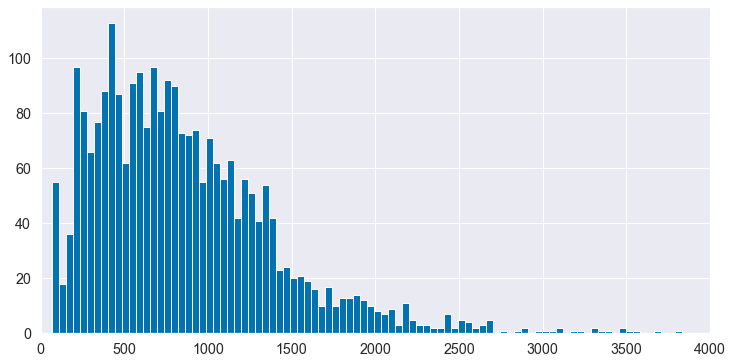

In [148]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
metadata['length'].hist(ax=ax, bins=100)
ax.set_xlim(0, 4000);

In [144]:
metadata['length'].min(), metadata['length'].max(), int(metadata['length'].mean())

(69, 4248, 859)

## Common genes

In [162]:
%%time
gene_name_counts = collections.defaultdict(int)
n_species = len(species_w_seq)
for i, tpl in enumerate(species_w_seq.itertuples()):
    specie_name = tpl.specie_name
    print(f'{i + 1} / {n_species} - {specie_name}')
    specie_name_formatted = specie_name.lower().replace(' ', '_')
    gff_path = os.path.join(ncbi_folder, f'{specie_name_formatted}.gff')
    annotations = gffutils.create_db(gff_path, ':memory:', merge_strategy='replace')
    specie_genes_set = set()
    for f in annotations.features_of_type('gene'):
        if 'Name' in f.attributes and len(f.attributes['Name']) > 0:
            name = f.attributes['Name'][0]
            if name not in specie_genes_set:
                gene_name_counts[name] += 1
                specie_genes_set.add(name)

1 / 2348 - Acetobacter aceti
2 / 2348 - Acetobacter cerevisiae
3 / 2348 - Acetobacter pasteurianus
4 / 2348 - Acetobacter orleanensis
5 / 2348 - Acetobacter pomorum
6 / 2348 - Acetobacter malorum
7 / 2348 - Acetobacter syzygii
8 / 2348 - Acetobacter cibinongensis
9 / 2348 - Acetobacter orientalis
10 / 2348 - Acetobacter tropicalis
11 / 2348 - Acetobacter indonesiensis
12 / 2348 - Acetobacter nitrogenifigens
13 / 2348 - Acetobacter senegalensis
14 / 2348 - Acetobacter ghanensis
15 / 2348 - Acidiphilium multivorum
16 / 2348 - Acidocella aminolytica
17 / 2348 - Acidomonas methanolica
18 / 2348 - Asaia astilbis
19 / 2348 - Asaia platycodi
20 / 2348 - Asaia prunellae
21 / 2348 - Belnapia moabensis
22 / 2348 - Belnapia rosea
23 / 2348 - Gluconacetobacter diazotrophicus
24 / 2348 - Gluconobacter oxydans
25 / 2348 - Gluconobacter cerinus
26 / 2348 - Kozakia baliensis
27 / 2348 - Rubritepida flocculans
28 / 2348 - Saccharibacter floricola
29 / 2348 - Acidisphaera rubrifaciens
30 / 2348 - Murico

231 / 2348 - Aurantimonas manganoxydans
232 / 2348 - Fulvimarina pelagi
233 / 2348 - Martelella mediterranea
234 / 2348 - Aureimonas altamirensis
235 / 2348 - Aureimonas ureilytica
236 / 2348 - Aureimonas frigidaquae
237 / 2348 - Alkalibacillus haloalkaliphilus
238 / 2348 - Anoxybacillus flavithermus
239 / 2348 - Anoxybacillus pushchinoensis
240 / 2348 - Anoxybacillus tepidamans
241 / 2348 - Anoxybacillus amylolyticus
242 / 2348 - Anoxybacillus thermarum
243 / 2348 - Viridibacillus arvi
244 / 2348 - Viridibacillus arenosi
245 / 2348 - Bacillus alcalophilus
246 / 2348 - Bacillus aminovorans
247 / 2348 - Bacillus amyloliquefaciens
248 / 2348 - Bacillus azotoformans
249 / 2348 - Bacillus encimensis
250 / 2348 - Bacillus cereus
251 / 2348 - Bacillus mycoides
252 / 2348 - Bacillus circulans
253 / 2348 - Bacillus coagulans
254 / 2348 - Bacillus fastidiosus
255 / 2348 - Bacillus firmus
256 / 2348 - Bacillus flexus
257 / 2348 - Bacillus lentus
258 / 2348 - Bacillus licheniformis
259 / 2348 - B

456 / 2348 - Bacteroides coprosuis
457 / 2348 - Bacteroides barnesiae
458 / 2348 - Bacteroides salanitronis
459 / 2348 - Bacteroides gallinarum
460 / 2348 - Bacteroides caccae
461 / 2348 - Bacteroides stercoris
462 / 2348 - Bacteroides salyersiae
463 / 2348 - Bacteroides propionicifaciens
464 / 2348 - Bacteroides coprophilus
465 / 2348 - Bacteroides cellulosilyticus
466 / 2348 - Bacteroides graminisolvens
467 / 2348 - Bacteroides paurosaccharolyticus
468 / 2348 - Bacteroides xylanisolvens
469 / 2348 - Bacteroides clarus
470 / 2348 - Bacteroides fluxus
471 / 2348 - Bacteroides oleiciplenus
472 / 2348 - Bacteroides faecis
473 / 2348 - Bartonella schoenbuchensis
474 / 2348 - Bartonella quintana
475 / 2348 - Bartonella alsatica
476 / 2348 - Bartonella koehlerae
477 / 2348 - Bartonella birtlesii
478 / 2348 - Bartonella bovis
479 / 2348 - Bartonella queenslandensis
480 / 2348 - Bartonella rattaustraliani
481 / 2348 - Bartonella rochalimae
482 / 2348 - Bdellovibrio bacteriovorus
483 / 2348 - 

676 / 2348 - Cardiobacterium valvarum
677 / 2348 - Dichelobacter nodosus
678 / 2348 - Suttonella ornithocola
679 / 2348 - Alkalibacterium thalassium
680 / 2348 - Alkalibacterium putridalgicola
681 / 2348 - Alkalibacterium pelagium
682 / 2348 - Alkalibacterium subtropicum
683 / 2348 - Allofustis seminis
684 / 2348 - Alloiococcus otitis
685 / 2348 - Atopococcus tabaci
686 / 2348 - Atopostipes suicloacalis
687 / 2348 - Carnobacterium divergens
688 / 2348 - Carnobacterium gallinarum
689 / 2348 - Carnobacterium mobile
690 / 2348 - Carnobacterium maltaromaticum
691 / 2348 - Carnobacterium funditum
692 / 2348 - Carnobacterium alterfunditum
693 / 2348 - Carnobacterium inhibens
694 / 2348 - Carnobacterium viridans
695 / 2348 - Carnobacterium pleistocenium
696 / 2348 - Carnobacterium jeotgali
697 / 2348 - Desemzia incerta
698 / 2348 - Granulicatella adiacens
699 / 2348 - Granulicatella elegans
700 / 2348 - Granulicatella balaenopterae
701 / 2348 - Isobaculum melis
702 / 2348 - Marinilactibacillu

895 / 2348 - Butyricicoccus pullicaecorum
896 / 2348 - Proteiniclasticum ruminis
897 / 2348 - Colwellia psychrerythraea
898 / 2348 - Colwellia chukchiensis
899 / 2348 - Thalassomonas viridans
900 / 2348 - Thalassotalea agarivorans
901 / 2348 - Acidovorax delafieldii
902 / 2348 - Acidovorax avenae
903 / 2348 - Acidovorax temperans
904 / 2348 - Acidovorax konjaci
905 / 2348 - Acidovorax valerianellae
906 / 2348 - Acidovorax citrulli
907 / 2348 - Acidovorax cattleyae
908 / 2348 - Acidovorax caeni
909 / 2348 - Acidovorax soli
910 / 2348 - Acidovorax radicis
911 / 2348 - Alicycliphilus denitrificans
912 / 2348 - Brachymonas denitrificans
913 / 2348 - Brachymonas chironomi
914 / 2348 - Comamonas testosteroni
915 / 2348 - Comamonas terrigena
916 / 2348 - Comamonas aquatica
917 / 2348 - Comamonas kerstersii
918 / 2348 - Comamonas badia
919 / 2348 - Comamonas thiooxydans
920 / 2348 - Comamonas granuli
921 / 2348 - Comamonas composti
922 / 2348 - Curvibacter delicatus
923 / 2348 - Delftia acidov

1113 / 2348 - Demetria terragena
1114 / 2348 - Dermacoccus nishinomiyaensis
1115 / 2348 - Kytococcus sedentarius
1116 / 2348 - Kytococcus aerolatus
1117 / 2348 - Dermatophilus congolensis
1118 / 2348 - Kineosphaera limosa
1119 / 2348 - Austwickia chelonae
1120 / 2348 - Mobilicoccus pelagius
1121 / 2348 - Piscicoccus intestinalis
1122 / 2348 - Desulfatibacillum aliphaticivorans
1123 / 2348 - Desulfatibacillum alkenivorans
1124 / 2348 - Desulfospira joergensenii
1125 / 2348 - Desulfotignum balticum
1126 / 2348 - Desulfotignum phosphitoxidans
1127 / 2348 - Desulfobacter curvatus
1128 / 2348 - Desulfobacter postgatei
1129 / 2348 - Desulfobacter vibrioformis
1130 / 2348 - Desulfobacterium autotrophicum
1131 / 2348 - Desulfobacterium vacuolatum
1132 / 2348 - Desulfatiglans anilini
1133 / 2348 - Desulfobacterium oleovorans
1134 / 2348 - Desulfobacula phenolica
1135 / 2348 - Desulfobacula toluolica
1136 / 2348 - Desulfococcus multivorans
1137 / 2348 - Desulforegula conservatrix
1138 / 2348 - D

1332 / 2348 - Providencia burhodogranariea
1333 / 2348 - Providencia sneebia
1334 / 2348 - Rahnella aquatilis
1335 / 2348 - Raoultella planticola
1336 / 2348 - Raoultella terrigena
1337 / 2348 - Raoultella ornithinolytica
1338 / 2348 - Salmonella bongori
1339 / 2348 - Serratia ficaria
1340 / 2348 - Serratia fonticola
1341 / 2348 - Serratia marcescens
1342 / 2348 - Serratia odorifera
1343 / 2348 - Serratia plymuthica
1344 / 2348 - Serratia proteamaculans
1345 / 2348 - Serratia rubidaea
1346 / 2348 - Serratia liquefaciens
1347 / 2348 - Serratia grimesii
1348 / 2348 - Serratia ureilytica
1349 / 2348 - Serratia nematodiphila
1350 / 2348 - Serratia symbiotica
1351 / 2348 - Shigella flexneri
1352 / 2348 - Shigella sonnei
1353 / 2348 - Shigella boydii
1354 / 2348 - Sodalis glossinidius
1355 / 2348 - Tatumella ptyseos
1356 / 2348 - Tatumella citrea
1357 / 2348 - Tatumella morbirosei
1358 / 2348 - Trabulsiella guamensis
1359 / 2348 - Trabulsiella odontotermitis
1360 / 2348 - Xenorhabdus nematop

1553 / 2348 - Flavobacterium cucumis
1554 / 2348 - Flavobacterium defluvii
1555 / 2348 - Flavobacterium hercynium
1556 / 2348 - Flavobacterium filum
1557 / 2348 - Flavobacterium anhuiense
1558 / 2348 - Flavobacterium sasangense
1559 / 2348 - Flavobacterium rivuli
1560 / 2348 - Flavobacterium subsaxonicum
1561 / 2348 - Flavobacterium reichenbachii
1562 / 2348 - Flavobacterium swingsii
1563 / 2348 - Flavobacterium fluvii
1564 / 2348 - Flavobacterium haoranii
1565 / 2348 - Flavobacterium phragmitis
1566 / 2348 - Flavobacterium araucananum
1567 / 2348 - Flavobacterium chilense
1568 / 2348 - Formosa agariphila
1569 / 2348 - Gaetbulibacter saemankumensis
1570 / 2348 - Aquimarina muelleri
1571 / 2348 - Aquimarina spongiae
1572 / 2348 - Aquimarina agarilytica
1573 / 2348 - Gelidibacter algens
1574 / 2348 - Gelidibacter mesophilus
1575 / 2348 - Gillisia limnaea
1576 / 2348 - Leeuwenhoekiella marinoflava
1577 / 2348 - Leeuwenhoekiella palythoae
1578 / 2348 - Maribacter sedimenticola
1579 / 2348 

1767 / 2348 - Psychrobacter aquaticus
1768 / 2348 - Psychrobacter cryohalolentis
1769 / 2348 - Psychrobacter arcticus
1770 / 2348 - Psychrobacter lutiphocae
1771 / 2348 - Moritella viscosa
1772 / 2348 - Moritella dasanensis
1773 / 2348 - Mycobacterium xenopi
1774 / 2348 - Mycobacterium heckeshornense
1775 / 2348 - Mycobacterium pseudoshottsii
1776 / 2348 - Mycobacterium chelonae
1777 / 2348 - Hoyosella subflava
1778 / 2348 - Nitratiruptor tergarcus
1779 / 2348 - Caminibacter mediatlanticus
1780 / 2348 - Nautilia profundicola
1781 / 2348 - Chromobacterium pseudoviolaceum
1782 / 2348 - Neisseria animaloris
1783 / 2348 - Neisseria zoodegmatis
1784 / 2348 - Thermodesulfovibrio yellowstonii
1785 / 2348 - Thermodesulfovibrio islandicus
1786 / 2348 - Thermodesulfovibrio aggregans
1787 / 2348 - Thermodesulfovibrio thiophilus
1788 / 2348 - Nocardia crassostreae
1789 / 2348 - Rhodococcus fascians
1790 / 2348 - Rhodococcus marinonascens
1791 / 2348 - Rhodococcus opacus
1792 / 2348 - Smaragdicoccu

1982 / 2348 - Kroppenstedtia eburnea
1983 / 2348 - Ammonifex degensii
1984 / 2348 - Caldanaerobacter subterraneus
1985 / 2348 - Tepidanaerobacter syntrophicus
1986 / 2348 - Thermanaeromonas toyohensis
1987 / 2348 - Carboxydothermus hydrogenoformans
1988 / 2348 - Carboxydothermus ferrireducens
1989 / 2348 - Carboxydothermus islandicus
1990 / 2348 - Carboxydothermus pertinax
1991 / 2348 - Moorella thermoacetica
1992 / 2348 - Moorella glycerini
1993 / 2348 - Moorella mulderi
1994 / 2348 - Thermoanaerobacter kivui
1995 / 2348 - Thermoanaerobacter thermohydrosulfuricus
1996 / 2348 - Thermoanaerobacter brockii
1997 / 2348 - Thermoanaerobacter cellulolyticus
1998 / 2348 - Thermoanaerobacter italicus
1999 / 2348 - Thermoanaerobacter wiegelii
2000 / 2348 - Thermoanaerobacter mathranii
2001 / 2348 - Thermoanaerobacter siderophilus
2002 / 2348 - Thermoanaerobacter uzonensis
2003 / 2348 - Thermoanaerobacter pseudethanolicus
2004 / 2348 - Desulfovirgula thermocuniculi
2005 / 2348 - Caldanaerobius f

2189 / 2348 - Carnobacterium iners
2190 / 2348 - Fervidicella metallireducens
2191 / 2348 - Rhodoferax saidenbachensis
2192 / 2348 - Ferrimonas sediminum
2193 / 2348 - Aquimarina amphilecti
2194 / 2348 - Chryseobacterium frigidisoli
2195 / 2348 - Olleya namhaensis
2196 / 2348 - Haloferax larsenii
2197 / 2348 - Haloferax elongans
2198 / 2348 - Haloferax mucosum
2199 / 2348 - Halopiger salifodinae
2200 / 2348 - Sulfurimonas gotlandica
2201 / 2348 - Tepidiphilus thermophilus
2202 / 2348 - Methylomarinum vadi
2203 / 2348 - Cryobacterium flavum
2204 / 2348 - Cryobacterium levicorallinum
2205 / 2348 - Nocardioides szechwanensis
2206 / 2348 - Nocardioides psychrotolerans
2207 / 2348 - Paenibacillus darwinianus
2208 / 2348 - Desulfofarcimen intricatum
2209 / 2348 - Paenisporosarcina indica
2210 / 2348 - Phaeobacter gallaeciensis
2211 / 2348 - Pseudophaeobacter leonis
2212 / 2348 - Roseovarius marisflavi
2213 / 2348 - Limimonas halophila
2214 / 2348 - Thermus tengchongensis
2215 / 2348 - Thermu

In [163]:
sorted_genes = sorted([
    (name, gene_name_counts[name], round(100 * gene_name_counts[name] / n_species, 2)) 
    for name in gene_name_counts.keys()
], key=lambda r: r[1], reverse=True)

In [171]:
for i, r in enumerate(sorted_genes[:30]):
    print(i + 1, r)

1 ('rnpB', 2300, 97.96)
2 ('ffs', 2252, 95.91)
3 ('rrf', 2234, 95.14)
4 ('ssrA', 2226, 94.8)
5 ('rpsR', 1980, 84.33)
6 ('rpmG', 1979, 84.28)
7 ('rplK', 1976, 84.16)
8 ('fusA', 1973, 84.03)
9 ('map', 1966, 83.73)
10 ('rplU', 1965, 83.69)
11 ('glmS', 1962, 83.56)
12 ('recA', 1957, 83.35)
13 ('efp', 1955, 83.26)
14 ('rpsB', 1951, 83.09)
15 ('pyk', 1941, 82.67)
16 ('gyrB', 1940, 82.62)
17 ('nusA', 1939, 82.58)
18 ('groL', 1935, 82.41)
19 ('pyrF', 1932, 82.28)
20 ('purE', 1923, 81.9)
21 ('lepB', 1918, 81.69)
22 ('rpsH', 1917, 81.64)
23 ('tsaD', 1915, 81.56)
24 ('tuf', 1912, 81.43)
25 ('rsmI', 1910, 81.35)
26 ('trxA', 1908, 81.26)
27 ('hflX', 1900, 80.92)
28 ('trxB', 1896, 80.75)
29 ('murA', 1879, 80.03)
30 ('carB', 1875, 79.86)


In [188]:
selected_genes = [t[0] for t in sorted_genes[:30]]
selected_genes_set = set(selected_genes)

In [344]:
def extract_sequences(species_df, ncbi_folder, gene_names):
    n_species = len(species_df)
    all_metadata = []
    all_sequences = []
    columns = None
    for i, tpl in enumerate(species_df.itertuples()):
        specie_name = tpl.specie_name
        print(f'{i + 1} / {n_species} - {specie_name}')
        sequences, metadata = get_gene_sequences(ncbi_folder, specie_name, gene_names=gene_names)
        metadata['temperature'] = tpl.temperature
        metadata['temperature_range'] = tpl.temperature_range
        all_sequences.extend(sequences)
        all_metadata.extend(metadata.values.tolist())
        if columns is None:
            columns = metadata.columns
        
    dataset = pd.DataFrame(all_metadata, columns=columns)
    dataset['sequence'] = all_sequences
    
    return dataset

In [345]:
dataset_df = extract_sequences(species_w_seq, ncbi_folder, selected_genes_set)

1 / 2348 - Acetobacter aceti
2 / 2348 - Acetobacter cerevisiae
3 / 2348 - Acetobacter pasteurianus
4 / 2348 - Acetobacter orleanensis
5 / 2348 - Acetobacter pomorum
6 / 2348 - Acetobacter malorum
7 / 2348 - Acetobacter syzygii
8 / 2348 - Acetobacter cibinongensis
9 / 2348 - Acetobacter orientalis
10 / 2348 - Acetobacter tropicalis
11 / 2348 - Acetobacter indonesiensis
12 / 2348 - Acetobacter nitrogenifigens
13 / 2348 - Acetobacter senegalensis
14 / 2348 - Acetobacter ghanensis
15 / 2348 - Acidiphilium multivorum
16 / 2348 - Acidocella aminolytica
17 / 2348 - Acidomonas methanolica
18 / 2348 - Asaia astilbis
19 / 2348 - Asaia platycodi
20 / 2348 - Asaia prunellae
21 / 2348 - Belnapia moabensis
22 / 2348 - Belnapia rosea
23 / 2348 - Gluconacetobacter diazotrophicus
24 / 2348 - Gluconobacter oxydans
25 / 2348 - Gluconobacter cerinus
26 / 2348 - Kozakia baliensis
27 / 2348 - Rubritepida flocculans
28 / 2348 - Saccharibacter floricola
29 / 2348 - Acidisphaera rubrifaciens
30 / 2348 - Murico

231 / 2348 - Aurantimonas manganoxydans
232 / 2348 - Fulvimarina pelagi
233 / 2348 - Martelella mediterranea
234 / 2348 - Aureimonas altamirensis
235 / 2348 - Aureimonas ureilytica
236 / 2348 - Aureimonas frigidaquae
237 / 2348 - Alkalibacillus haloalkaliphilus
238 / 2348 - Anoxybacillus flavithermus
239 / 2348 - Anoxybacillus pushchinoensis
240 / 2348 - Anoxybacillus tepidamans
241 / 2348 - Anoxybacillus amylolyticus
242 / 2348 - Anoxybacillus thermarum
243 / 2348 - Viridibacillus arvi
244 / 2348 - Viridibacillus arenosi
245 / 2348 - Bacillus alcalophilus
246 / 2348 - Bacillus aminovorans
247 / 2348 - Bacillus amyloliquefaciens
248 / 2348 - Bacillus azotoformans
249 / 2348 - Bacillus encimensis
250 / 2348 - Bacillus cereus
251 / 2348 - Bacillus mycoides
252 / 2348 - Bacillus circulans
253 / 2348 - Bacillus coagulans
254 / 2348 - Bacillus fastidiosus
255 / 2348 - Bacillus firmus
256 / 2348 - Bacillus flexus
257 / 2348 - Bacillus lentus
258 / 2348 - Bacillus licheniformis
259 / 2348 - B

456 / 2348 - Bacteroides coprosuis
457 / 2348 - Bacteroides barnesiae
458 / 2348 - Bacteroides salanitronis
459 / 2348 - Bacteroides gallinarum
460 / 2348 - Bacteroides caccae
461 / 2348 - Bacteroides stercoris
462 / 2348 - Bacteroides salyersiae
463 / 2348 - Bacteroides propionicifaciens
464 / 2348 - Bacteroides coprophilus
465 / 2348 - Bacteroides cellulosilyticus
466 / 2348 - Bacteroides graminisolvens
467 / 2348 - Bacteroides paurosaccharolyticus
468 / 2348 - Bacteroides xylanisolvens
469 / 2348 - Bacteroides clarus
470 / 2348 - Bacteroides fluxus
471 / 2348 - Bacteroides oleiciplenus
472 / 2348 - Bacteroides faecis
473 / 2348 - Bartonella schoenbuchensis
474 / 2348 - Bartonella quintana
475 / 2348 - Bartonella alsatica
476 / 2348 - Bartonella koehlerae
477 / 2348 - Bartonella birtlesii
478 / 2348 - Bartonella bovis
479 / 2348 - Bartonella queenslandensis
480 / 2348 - Bartonella rattaustraliani
481 / 2348 - Bartonella rochalimae
482 / 2348 - Bdellovibrio bacteriovorus
483 / 2348 - 

676 / 2348 - Cardiobacterium valvarum
677 / 2348 - Dichelobacter nodosus
678 / 2348 - Suttonella ornithocola
679 / 2348 - Alkalibacterium thalassium
680 / 2348 - Alkalibacterium putridalgicola
681 / 2348 - Alkalibacterium pelagium
682 / 2348 - Alkalibacterium subtropicum
683 / 2348 - Allofustis seminis
684 / 2348 - Alloiococcus otitis
685 / 2348 - Atopococcus tabaci
686 / 2348 - Atopostipes suicloacalis
687 / 2348 - Carnobacterium divergens
688 / 2348 - Carnobacterium gallinarum
689 / 2348 - Carnobacterium mobile
690 / 2348 - Carnobacterium maltaromaticum
691 / 2348 - Carnobacterium funditum
692 / 2348 - Carnobacterium alterfunditum
693 / 2348 - Carnobacterium inhibens
694 / 2348 - Carnobacterium viridans
695 / 2348 - Carnobacterium pleistocenium
696 / 2348 - Carnobacterium jeotgali
697 / 2348 - Desemzia incerta
698 / 2348 - Granulicatella adiacens
699 / 2348 - Granulicatella elegans
700 / 2348 - Granulicatella balaenopterae
701 / 2348 - Isobaculum melis
702 / 2348 - Marinilactibacillu

895 / 2348 - Butyricicoccus pullicaecorum
896 / 2348 - Proteiniclasticum ruminis
897 / 2348 - Colwellia psychrerythraea
898 / 2348 - Colwellia chukchiensis
899 / 2348 - Thalassomonas viridans
900 / 2348 - Thalassotalea agarivorans
901 / 2348 - Acidovorax delafieldii
902 / 2348 - Acidovorax avenae
903 / 2348 - Acidovorax temperans
904 / 2348 - Acidovorax konjaci
905 / 2348 - Acidovorax valerianellae
906 / 2348 - Acidovorax citrulli
907 / 2348 - Acidovorax cattleyae
908 / 2348 - Acidovorax caeni
909 / 2348 - Acidovorax soli
910 / 2348 - Acidovorax radicis
911 / 2348 - Alicycliphilus denitrificans
912 / 2348 - Brachymonas denitrificans
913 / 2348 - Brachymonas chironomi
914 / 2348 - Comamonas testosteroni
915 / 2348 - Comamonas terrigena
916 / 2348 - Comamonas aquatica
917 / 2348 - Comamonas kerstersii
918 / 2348 - Comamonas badia
919 / 2348 - Comamonas thiooxydans
920 / 2348 - Comamonas granuli
921 / 2348 - Comamonas composti
922 / 2348 - Curvibacter delicatus
923 / 2348 - Delftia acidov

1113 / 2348 - Demetria terragena
1114 / 2348 - Dermacoccus nishinomiyaensis
1115 / 2348 - Kytococcus sedentarius
1116 / 2348 - Kytococcus aerolatus
1117 / 2348 - Dermatophilus congolensis
1118 / 2348 - Kineosphaera limosa
1119 / 2348 - Austwickia chelonae
1120 / 2348 - Mobilicoccus pelagius
1121 / 2348 - Piscicoccus intestinalis
1122 / 2348 - Desulfatibacillum aliphaticivorans
1123 / 2348 - Desulfatibacillum alkenivorans
1124 / 2348 - Desulfospira joergensenii
1125 / 2348 - Desulfotignum balticum
1126 / 2348 - Desulfotignum phosphitoxidans
1127 / 2348 - Desulfobacter curvatus
1128 / 2348 - Desulfobacter postgatei
1129 / 2348 - Desulfobacter vibrioformis
1130 / 2348 - Desulfobacterium autotrophicum
1131 / 2348 - Desulfobacterium vacuolatum
1132 / 2348 - Desulfatiglans anilini
1133 / 2348 - Desulfobacterium oleovorans
1134 / 2348 - Desulfobacula phenolica
1135 / 2348 - Desulfobacula toluolica
1136 / 2348 - Desulfococcus multivorans
1137 / 2348 - Desulforegula conservatrix
1138 / 2348 - D

1332 / 2348 - Providencia burhodogranariea
1333 / 2348 - Providencia sneebia
1334 / 2348 - Rahnella aquatilis
1335 / 2348 - Raoultella planticola
1336 / 2348 - Raoultella terrigena
1337 / 2348 - Raoultella ornithinolytica
1338 / 2348 - Salmonella bongori
1339 / 2348 - Serratia ficaria
1340 / 2348 - Serratia fonticola
1341 / 2348 - Serratia marcescens
1342 / 2348 - Serratia odorifera
1343 / 2348 - Serratia plymuthica
1344 / 2348 - Serratia proteamaculans
1345 / 2348 - Serratia rubidaea
1346 / 2348 - Serratia liquefaciens
1347 / 2348 - Serratia grimesii
1348 / 2348 - Serratia ureilytica
1349 / 2348 - Serratia nematodiphila
1350 / 2348 - Serratia symbiotica
1351 / 2348 - Shigella flexneri
1352 / 2348 - Shigella sonnei
1353 / 2348 - Shigella boydii
1354 / 2348 - Sodalis glossinidius
1355 / 2348 - Tatumella ptyseos
1356 / 2348 - Tatumella citrea
1357 / 2348 - Tatumella morbirosei
1358 / 2348 - Trabulsiella guamensis
1359 / 2348 - Trabulsiella odontotermitis
1360 / 2348 - Xenorhabdus nematop

1553 / 2348 - Flavobacterium cucumis
1554 / 2348 - Flavobacterium defluvii
1555 / 2348 - Flavobacterium hercynium
1556 / 2348 - Flavobacterium filum
1557 / 2348 - Flavobacterium anhuiense
1558 / 2348 - Flavobacterium sasangense
1559 / 2348 - Flavobacterium rivuli
1560 / 2348 - Flavobacterium subsaxonicum
1561 / 2348 - Flavobacterium reichenbachii
1562 / 2348 - Flavobacterium swingsii
1563 / 2348 - Flavobacterium fluvii
1564 / 2348 - Flavobacterium haoranii
1565 / 2348 - Flavobacterium phragmitis
1566 / 2348 - Flavobacterium araucananum
1567 / 2348 - Flavobacterium chilense
1568 / 2348 - Formosa agariphila
1569 / 2348 - Gaetbulibacter saemankumensis
1570 / 2348 - Aquimarina muelleri
1571 / 2348 - Aquimarina spongiae
1572 / 2348 - Aquimarina agarilytica
1573 / 2348 - Gelidibacter algens
1574 / 2348 - Gelidibacter mesophilus
1575 / 2348 - Gillisia limnaea
1576 / 2348 - Leeuwenhoekiella marinoflava
1577 / 2348 - Leeuwenhoekiella palythoae
1578 / 2348 - Maribacter sedimenticola
1579 / 2348 

1767 / 2348 - Psychrobacter aquaticus
1768 / 2348 - Psychrobacter cryohalolentis
1769 / 2348 - Psychrobacter arcticus
1770 / 2348 - Psychrobacter lutiphocae
1771 / 2348 - Moritella viscosa
1772 / 2348 - Moritella dasanensis
1773 / 2348 - Mycobacterium xenopi
1774 / 2348 - Mycobacterium heckeshornense
1775 / 2348 - Mycobacterium pseudoshottsii
1776 / 2348 - Mycobacterium chelonae
1777 / 2348 - Hoyosella subflava
1778 / 2348 - Nitratiruptor tergarcus
1779 / 2348 - Caminibacter mediatlanticus
1780 / 2348 - Nautilia profundicola
1781 / 2348 - Chromobacterium pseudoviolaceum
1782 / 2348 - Neisseria animaloris
1783 / 2348 - Neisseria zoodegmatis
1784 / 2348 - Thermodesulfovibrio yellowstonii
1785 / 2348 - Thermodesulfovibrio islandicus
1786 / 2348 - Thermodesulfovibrio aggregans
1787 / 2348 - Thermodesulfovibrio thiophilus
1788 / 2348 - Nocardia crassostreae
1789 / 2348 - Rhodococcus fascians
1790 / 2348 - Rhodococcus marinonascens
1791 / 2348 - Rhodococcus opacus
1792 / 2348 - Smaragdicoccu

1982 / 2348 - Kroppenstedtia eburnea
1983 / 2348 - Ammonifex degensii
1984 / 2348 - Caldanaerobacter subterraneus
1985 / 2348 - Tepidanaerobacter syntrophicus
1986 / 2348 - Thermanaeromonas toyohensis
1987 / 2348 - Carboxydothermus hydrogenoformans
1988 / 2348 - Carboxydothermus ferrireducens
1989 / 2348 - Carboxydothermus islandicus
1990 / 2348 - Carboxydothermus pertinax
1991 / 2348 - Moorella thermoacetica
1992 / 2348 - Moorella glycerini
1993 / 2348 - Moorella mulderi
1994 / 2348 - Thermoanaerobacter kivui
1995 / 2348 - Thermoanaerobacter thermohydrosulfuricus
1996 / 2348 - Thermoanaerobacter brockii
1997 / 2348 - Thermoanaerobacter cellulolyticus
1998 / 2348 - Thermoanaerobacter italicus
1999 / 2348 - Thermoanaerobacter wiegelii
2000 / 2348 - Thermoanaerobacter mathranii
2001 / 2348 - Thermoanaerobacter siderophilus
2002 / 2348 - Thermoanaerobacter uzonensis
2003 / 2348 - Thermoanaerobacter pseudethanolicus
2004 / 2348 - Desulfovirgula thermocuniculi
2005 / 2348 - Caldanaerobius f

2189 / 2348 - Carnobacterium iners
2190 / 2348 - Fervidicella metallireducens
2191 / 2348 - Rhodoferax saidenbachensis
2192 / 2348 - Ferrimonas sediminum
2193 / 2348 - Aquimarina amphilecti
2194 / 2348 - Chryseobacterium frigidisoli
2195 / 2348 - Olleya namhaensis
2196 / 2348 - Haloferax larsenii
2197 / 2348 - Haloferax elongans
2198 / 2348 - Haloferax mucosum
2199 / 2348 - Halopiger salifodinae
2200 / 2348 - Sulfurimonas gotlandica
2201 / 2348 - Tepidiphilus thermophilus
2202 / 2348 - Methylomarinum vadi
2203 / 2348 - Cryobacterium flavum
2204 / 2348 - Cryobacterium levicorallinum
2205 / 2348 - Nocardioides szechwanensis
2206 / 2348 - Nocardioides psychrotolerans
2207 / 2348 - Paenibacillus darwinianus
2208 / 2348 - Desulfofarcimen intricatum
2209 / 2348 - Paenisporosarcina indica
2210 / 2348 - Phaeobacter gallaeciensis
2211 / 2348 - Pseudophaeobacter leonis
2212 / 2348 - Roseovarius marisflavi
2213 / 2348 - Limimonas halophila
2214 / 2348 - Thermus tengchongensis
2215 / 2348 - Thermu

In [346]:
dataset_df.shape

(59316, 10)

In [347]:
dataset_df.tail()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand,temperature,temperature_range,sequence
59311,Octadecabacter ascidiaceicola,NZ_FXYD01000004.1,trxA,27307,27628,321,+,10.0,psychrophilic,ATGGCCACCGTAGCAGTAACAGACGACACATTTGACGCAGAAGTTC...
59312,Octadecabacter ascidiaceicola,NZ_FXYD01000004.1,pyrF,301101,301800,699,-,10.0,psychrophilic,ATGACCACTGATGACCGCCTGATCGTTGCCTTGGATGTCCCTGACG...
59313,Octadecabacter ascidiaceicola,NZ_FXYD01000004.1,rrf,317187,317302,115,+,10.0,psychrophilic,TTTGGTGGTCATAGCACGAGTGAAACACCTGGCTCCATTCCGAACC...
59314,Octadecabacter ascidiaceicola,NZ_FXYD01000005.1,pyk,30830,32282,1452,+,10.0,psychrophilic,ATGAAACGTGATCGCAATGTTAAGATTGTCGCCACATTAGGCCCTG...
59315,Octadecabacter ascidiaceicola,NZ_FXYD01000005.1,ffs,56110,56209,99,-,10.0,psychrophilic,TGAGGGGTTGGCGCGGGCAAGTGCCTCGCCAACCTGGTCAGGTCCG...


In [348]:
output_path = os.path.join(os.getcwd(), 'data/ncbi/dataset.csv')
#dataset_df.to_csv(output_path, index=False)